In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

In [36]:
list_id = []
list_latitude = []
list_longitude = []
list_elevation = []
list_state = []

with open('data/ghcnd-stations.txt', 'r') as f:
    for line in f:
        # split the spaces
        list_line = line.split(' ')
        # delete the empty characters
        list_line = [line for line in list_line if line != '']

        # mapping file has the following columns:
        # id, latitude, longitude, elevation, state, name, gsn flag, wmo id
        # let's say that we don't care about name, gsn flag and wmo id
        # so we just want to keep the first 5 fields
        # we keep the state just for US contries, for other countries we put the first
        # two letters of the id
        if list_line[0][:2] == 'US':
            list_line = list_line[:5]
            state = list_line[4]
        else:
            list_line = list_line[:4]
            state = list_line[0][:2]
        
        list_id.append(list_line[0])
        list_latitude.append(list_line[1])
        list_longitude.append(list_line[2])
        list_elevation.append(list_line[3])
        list_state.append(state)


mapping_df = pd.DataFrame({
    'id': list_id,
    'latitude': list_latitude,
    'longitude': list_longitude,
    'elevation': list_elevation,
    'state': list_state
})

mapping_df['latitude'] = mapping_df['latitude'].astype(float)
mapping_df['longitude'] = mapping_df['longitude'].astype(float)
mapping_df['elevation'] = mapping_df['elevation'].astype(float)

mapping_df = mapping_df.set_index('id')



In [37]:
files = os.listdir('data')
files = [f for f in files if (('.csv' in f) and ('.gz' not in f))]

In [38]:
def format_dataset(filename):
    
    print(f"Working on file {filename}")

    dataset = pd.read_csv(filename, header=None, dtype={1: str, 7: str})

    dataset.columns = ['id', 'date', 'element', 'value', 'm_flag', 'q_flag', 's_flag', 'obs_time']
    dataset = dataset.loc[dataset['q_flag'].isna()]
    dataset = dataset.loc[dataset['s_flag'] == 'W']
    dataset = dataset.loc[dataset['element'].isin(['TMIN', 'TMAX'])]

    dataset['datetime'] = pd.to_datetime(dataset['date'], format='%Y%m%d')
    dataset = dataset[['datetime', 'id', 'value', 'element']]

    dataset = dataset.set_index(['datetime', 'id', 'element'])
    dataset = dataset['value'].unstack()

    dataset = dataset / 10 # temperature is in decimals of celsius degrees
    dataset = dataset.sort_index()

    # just keep US data
    us_ids = [a for a in list(dataset.index.get_level_values('id').unique()) if 'US' in a]
    dataset = dataset.loc[dataset.index.get_level_values('id').isin(us_ids)]

    return dataset

In [39]:
historical_temperatures = []

for file in files:
    temperature = format_dataset('data/' + file)

    historical_temperatures.append(temperature)

historical_temperatures = pd.concat(historical_temperatures)


Working on file data/2020.csv
Working on file data/2021.csv
Working on file data/2022.csv
Working on file data/2023.csv
Working on file data/2024.csv


In [40]:
historical_temperatures = historical_temperatures.join(mapping_df)

In [41]:
historical_temperatures.to_parquet('historical_temperatures.parquet')

In [42]:
# read the file with all the temperatures for each station
historical_temperatures = pd.read_parquet('historical_temperatures.parquet')
historical_temperatures

TMAX  TMIN  latitude  longitude  elevation state
datetime   id                                                           
2020-01-01 USC00035189  10.6  -1.0   35.6333   -91.1667     -999.9    AR
           USC00108076   5.6  -4.9   45.2000  -113.8667     1232.6    ID
           USC00115943  11.7  -4.3   38.3619   -88.8597      149.4    IL
           USC00219170   1.1  -7.1   43.6450   -95.5803      478.5    MN
           USC00244558   5.0   2.8   48.3042  -114.2642      903.1    MT
...                      ...   ...       ...        ...        ...   ...
2024-06-03 USW00094908  27.2  16.7   42.3983   -90.7092      317.0    IA
           USW00094967  25.0  13.3   46.8997   -95.0669      439.2    MN
           USW00094978  31.7  17.2   41.7631   -96.1797      312.1    NE
           USW00094982  31.1  17.2   41.6117   -90.5808      259.4    IA
           USW00094994  27.2  18.9   43.1561   -90.6775      203.0    WI

[1750619 rows x 6 columns]

<Axes: title={'center': 'Maximum Temperature for a single station [°C]'}, xlabel='datetime'>

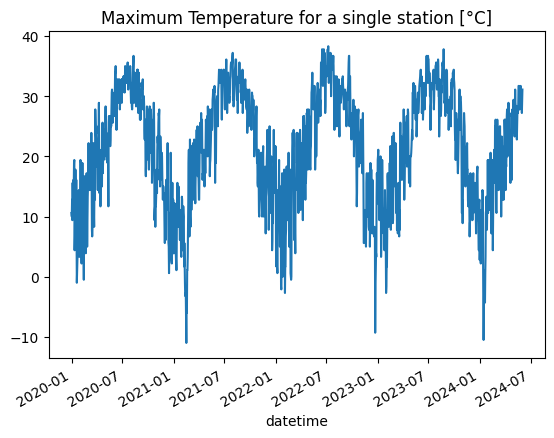

In [45]:
# pick a random station id and visualize the maximum temperature.
# it is clear that a seasonal pattern is present, this is a quite obvious
# and expected behavior
station_id = 'USC00035189'

historical_temperatures['TMAX'].unstack()[station_id].resample('D').asfreq().dropna().plot(
    title='Maximum Temperature for a single station [°C]'
)

Text(0.5, 1.0, 'Autocorrelation Plot of Maximum Temperature for a single station')

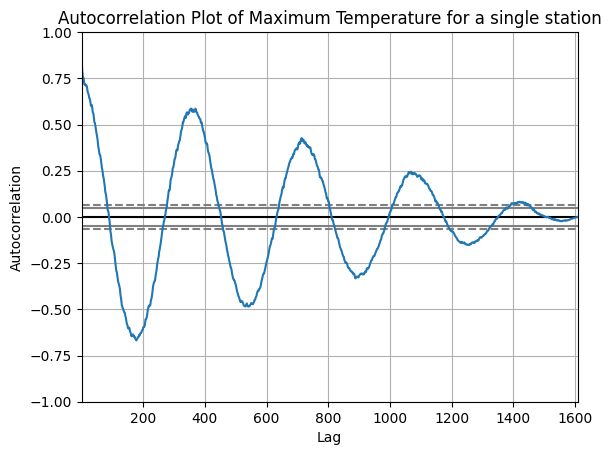

In [46]:
# autocorrelation plot of the maximum temperature of a single station
# as we expected, there is autocorrelation.
# The peaks correspond to alternate season, for example at 180 days lag we have a 
# minimum since the season is the opposite with respect to the season at day 0
# we have a maximum at 365 days lag since the season is the same
plt.figure()
pd.plotting.autocorrelation_plot(historical_temperatures['TMAX'].unstack()[station_id].resample('D').asfreq().dropna())
plt.title('Autocorrelation Plot of Maximum Temperature for a single station')

In [47]:
# this kind of data is not stationary, so we have to do something!
# we should remove the seasonality and check again 
adfuller(historical_temperatures['TMAX'].unstack()[station_id].resample('D').asfreq().dropna())

(-2.6310391700070244,
 0.08675027412447106,
 14,
 1593,
 {'1%': -3.434461656404719,
  '5%': -2.863356053770622,
  '10%': -2.567736831977157},
 8726.152495794277)

<Axes: title={'center': 'Deseasoned Maximum Temperature for a single station'}, xlabel='datetime'>

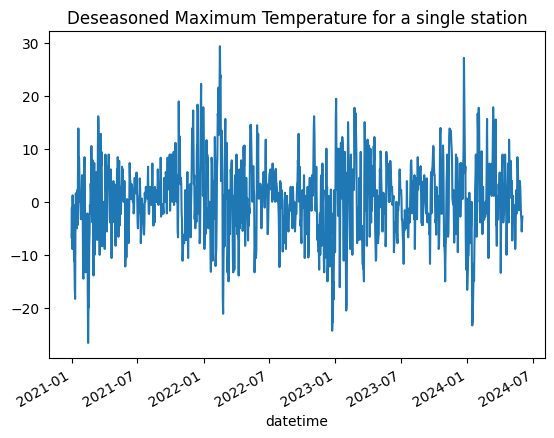

In [48]:
# let us now try to remove this kind of seasonality.
# an intuitive transformation could be to apply a diff(365), that is 
# subtracting the temperature of one year ago to each observations.
# In this way, we have the following
historical_temperatures['TMAX'].unstack()[station_id].resample('D').asfreq().diff(365).dropna().plot(title='Deseasoned Maximum Temperature for a single station')

Text(0.5, 1.0, 'Autocorrelation Plot for annual difference in Max Temperature for a single station')

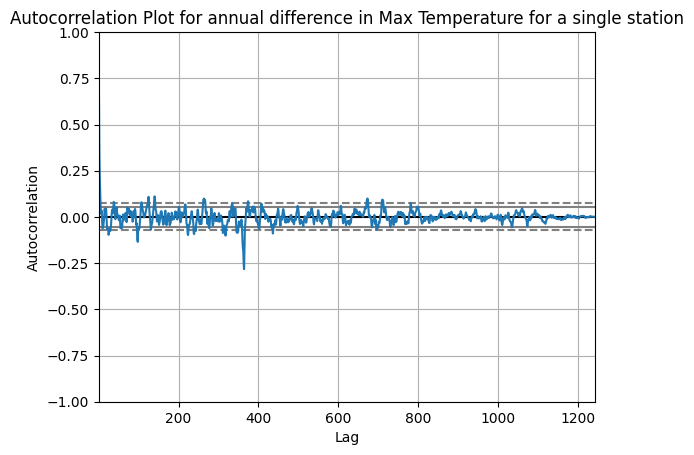

In [49]:
# we can now see that the autocorrelation plot is much better than before
# we still have some pattern that we could explore, but let us move forward
plt.figure()
pd.plotting.autocorrelation_plot(historical_temperatures['TMAX'].unstack()[station_id].resample('D').asfreq().diff(365).dropna())
plt.title('Autocorrelation Plot for annual difference in Max Temperature for a single station')

In [50]:
# as expected, the deseasoned data behave better and it passes the stationarity test
adfuller(historical_temperatures['TMAX'].unstack()[station_id].resample('D').asfreq().diff(365).dropna())

(-11.083622506092746,
 4.25032860131011e-20,
 8,
 1233,
 {'1%': -3.4356646522289815,
  '5%': -2.863886926389418,
  '10%': -2.568019536239491},
 7514.712014262817)